Extract the first item from the 'closest_topic_client' array.
Preprocess this text (e.g., tokenization, removing stopwords).
Train a Word2Vec model on this preprocessed text or use a pre-trained model.
Convert the topic text for each entry into a vector using Word2Vec.
Train Logistic Regression, Naive Bayes, and XGBoost models using these vectors.
Evaluate the models.

In [71]:
import pandas as pd

data = pd.read_csv('datasets/topic-model-new-features.csv')

In [39]:
data.head()

,closes_topic_scores,closest_topic_client,link,race_discussed,race_label,first_topic,text
0,"[0.21930881131517083, 0.20469330950065276, 0.2...","['Economy', 'Shopping', 'Taxes']",NaN,0,N/A - not specified,Economy,It has been nearly three years since auto plan...
1,"[0.31846321068945627, 0.28003363010451693, 0.2...","['Housing/Homelessness', 'Gentrification', 'Go...",NaN,0,N/A - not specified,Housing/Homelessness,The Boston City Council Wednesday approved pro...
2,"[0.28119502602711755, 0.2675696225469335, 0.24...","['Guns', 'Housing/Homelessness', 'GBH']",NaN,0,N/A - not specified,Guns,"So far this year, 16 people have been murdered..."
3,"[0.22247090584958581, 0.21474644664311154, 0.2...","['Addiction/Substance Use', 'Shopping', 'Small...",NaN,0,N/A - not specified,Addiction/Substance Use,Recently I spent the better part of two days i...
4,"[0.2954346807300122, 0.27083325201151054, 0.25...","['Equity & Justice', 'Civil Rights', 'Philanth...",NaN,1,Black,Equity & Justice,Communities across the nation are beginning th...


In [72]:
import gensim.downloader as api
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Preprocess the text: clean, tokenize
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens

# Apply preprocessing
data['tokens'] = data['text'].apply(preprocess_text)

# Load a pre-trained Word2Vec model
model_w2v = api.load('word2vec-google-news-300')

data['tokens'].head()


[nltk_data] Downloading package punkt to /Users/aninja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [it, has, been, nearly, three, years, since, a...
1    [the, boston, city, council, wednesday, approv...
2    [so, far, this, year, ,, 16, people, have, bee...
3    [recently, i, spent, the, better, part, of, tw...
4    [communities, across, the, nation, are, beginn...
Name: tokens, dtype: object

In [73]:
import numpy as np

# Function to create document vectors by averaging word vectors
def document_vector(doc_tokens):
    # Filter tokens that are in the model's vocabulary
    tokens = [token for token in doc_tokens if token in model_w2v.key_to_index]
    if not tokens:
        return np.zeros(model_w2v.vector_size)
    # Average the vectors for the tokens present in the model
    return np.mean(model_w2v[tokens], axis=0)

# Apply the function to create document vectors
data['doc_vectors'] = data['tokens'].apply(document_vector)

# Check the first document vector
print(data['doc_vectors'].iloc[0])


[ 4.03526835e-02  3.18679847e-02  1.63601562e-02  8.91017318e-02
 -5.52154481e-02 -4.48203720e-02  1.92381050e-02 -8.93669948e-02
  8.25808868e-02  7.54106566e-02 -5.78376874e-02 -6.44726306e-02
 -2.27553807e-02  1.43829966e-02 -1.06810257e-01  2.87513938e-02
  3.98121290e-02  6.73404559e-02 -5.67512070e-05 -2.31895763e-02
 -3.46388817e-02  8.77831411e-03 -3.03417700e-03 -3.77923772e-02
  4.31504808e-02  8.85649119e-03 -7.32793510e-02  6.96888864e-02
  3.19196470e-02 -1.90593384e-03 -3.29468064e-02  2.17052829e-03
 -3.01730037e-02 -3.57131916e-03  3.51697206e-02 -1.32946689e-02
 -9.93192475e-03 -1.92173161e-02  2.97709554e-02  5.07657975e-02
  9.37851369e-02 -3.64404507e-02  8.01099539e-02 -2.42132740e-03
 -4.19036523e-02 -2.27024201e-02 -7.28000887e-04  6.49632812e-02
  1.37258144e-02  1.30516915e-02  2.92408019e-02  3.31344008e-02
 -1.66007150e-02 -8.09443742e-03  4.43560630e-03  3.28644663e-02
 -2.65157875e-02 -2.78919190e-02  5.09532429e-02 -6.16895929e-02
 -5.59668429e-02  6.06295

the below code also changes accuracy

In [74]:
# WITHOUT TUNING  AND NO NEW FEATURES
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Prepare the features and labels
X = np.array(list(data['doc_vectors']))
y = data['race_discussed'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
log_reg = LogisticRegression()
naive_bayes = GaussianNB()
xgboost = GradientBoostingClassifier()

# Train the classifiers
log_reg.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Logistic Regression Accuracy: 0.6444444444444445
Naive Bayes Accuracy: 0.5333333333333333
XGBoost Accuracy: 0.6


In [75]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer


# Function to safely convert string representations of lists to actual lists
def safe_literal_eval(s):
    try:
        # Attempt to evaluate the string as a Python literal
        return ast.literal_eval(s)
    except ValueError:
        # Return an empty list or some other fallback if evaluation fails
        return []

# Apply this function to the 'closest_topic_client' column
data['topics_list'] = data['closest_topic_client'].apply(safe_literal_eval)

# Verify the transformation
# print(data['topics_list'].head())

mlb = MultiLabelBinarizer()

# Fit and transform the topics data into a one-hot encoded format
topics_encoded = mlb.fit_transform(data['topics_list'])

# Convert topics_encoded into a DataFrame
topics_df = pd.DataFrame(topics_encoded, columns=mlb.classes_)

# Show the first few rows to verify
print(topics_df.head())
#use the first topic out of the first
#other - couldnt find a match
#see how many 


   Abortion  Accessiblity/Disablity  Addiction/Substance Use  Aging/Seniors  \
0         0                       0                        0              0   
1         0                       0                        0              0   
2         0                       0                        0              0   
3         0                       0                        1              0   
4         0                       0                        0              0   

   Agriculture  Arts & Culture  Business & Finance  Childcare  Civil Rights  \
0            0               0                   0          0             0   
1            0               0                   0          0             0   
2            0               0                   0          0             0   
3            0               0                   0          0             0   
4            0               0                   0          0             1   

   Construction  ...  Shopping  Small Business  Sp

In [76]:
#WITH NEW FEATURES AND NO TUNING
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Assuming 'doc_vectors' is a list of NumPy arrays
doc_vectors_df = pd.DataFrame(list(data['doc_vectors']))

# Concatenate document vectors with topic features
features_df = pd.concat([doc_vectors_df, topics_df], axis=1)

# Prepare features and labels for training
X = features_df.values
y = data['race_discussed'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers
log_reg = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence
naive_bayes = GaussianNB()
xgboost = GradientBoostingClassifier()

# Train the classifiers
log_reg.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Logistic Regression Accuracy: 0.6444444444444445
Naive Bayes Accuracy: 0.4888888888888889
XGBoost Accuracy: 0.6


In [55]:
print(features_df.head())

          0         1         2         3         4         5         6  \
0  0.040353  0.031868  0.016360  0.089102 -0.055215 -0.044820  0.019238   
1  0.008453  0.035357  0.014600  0.072760 -0.057540 -0.057158  0.040900   
2 -0.007994  0.025085  0.041935  0.096307 -0.051994 -0.018207  0.022842   
3  0.029086  0.028367  0.027438  0.086934 -0.052087 -0.011998  0.028067   
4  0.025616  0.041634  0.035571  0.080978 -0.046535 -0.012404  0.046165   

          7         8         9  ...  Shopping  Small Business  Sports  \
0 -0.089367  0.082581  0.075411  ...         1               0       0   
1 -0.056641  0.057339  0.032341  ...         0               0       0   
2 -0.084940  0.053934  0.043572  ...         0               0       0   
3 -0.069334  0.076299  0.043116  ...         1               1       0   
4 -0.061127  0.082373  0.034296  ...         0               0       0   

   State Politics  Taxes  Technology  Terrorism  Veterans Affairs  Weather  \
0               0      1  

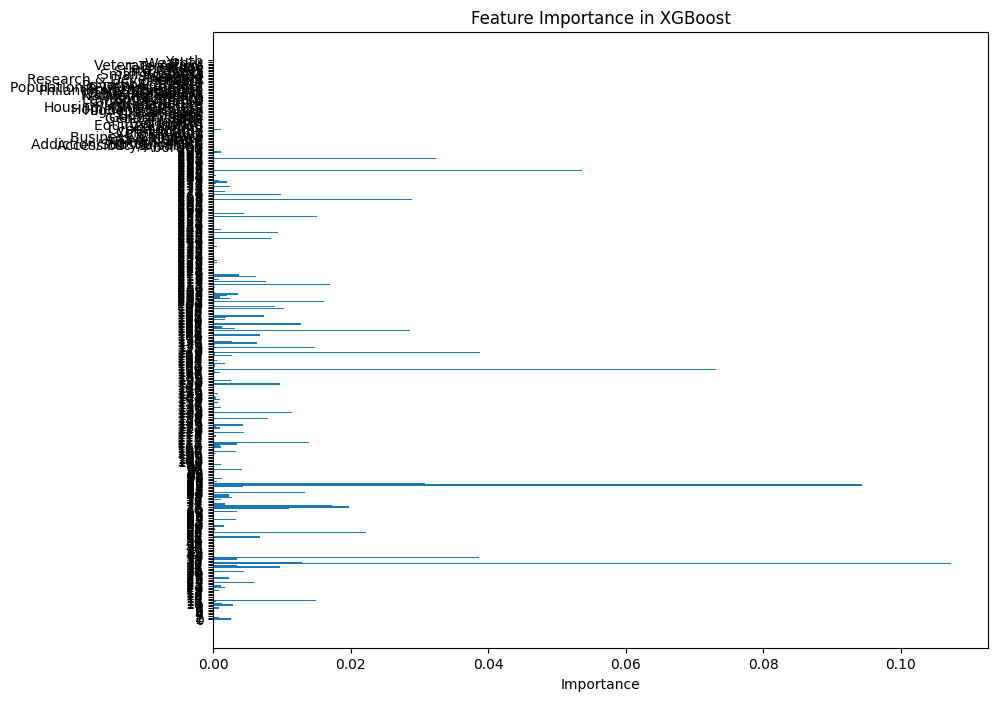

In [9]:
import matplotlib.pyplot as plt

# Train your XGBoost model
# xgboost.fit(X_train, y_train)
pr
# Feature importance
importance = xgboost.feature_importances_

# Visualize feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(importance)), importance)
plt.yticks(range(len(importance)), features_df.columns)  # Adjust to match the number of features
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()


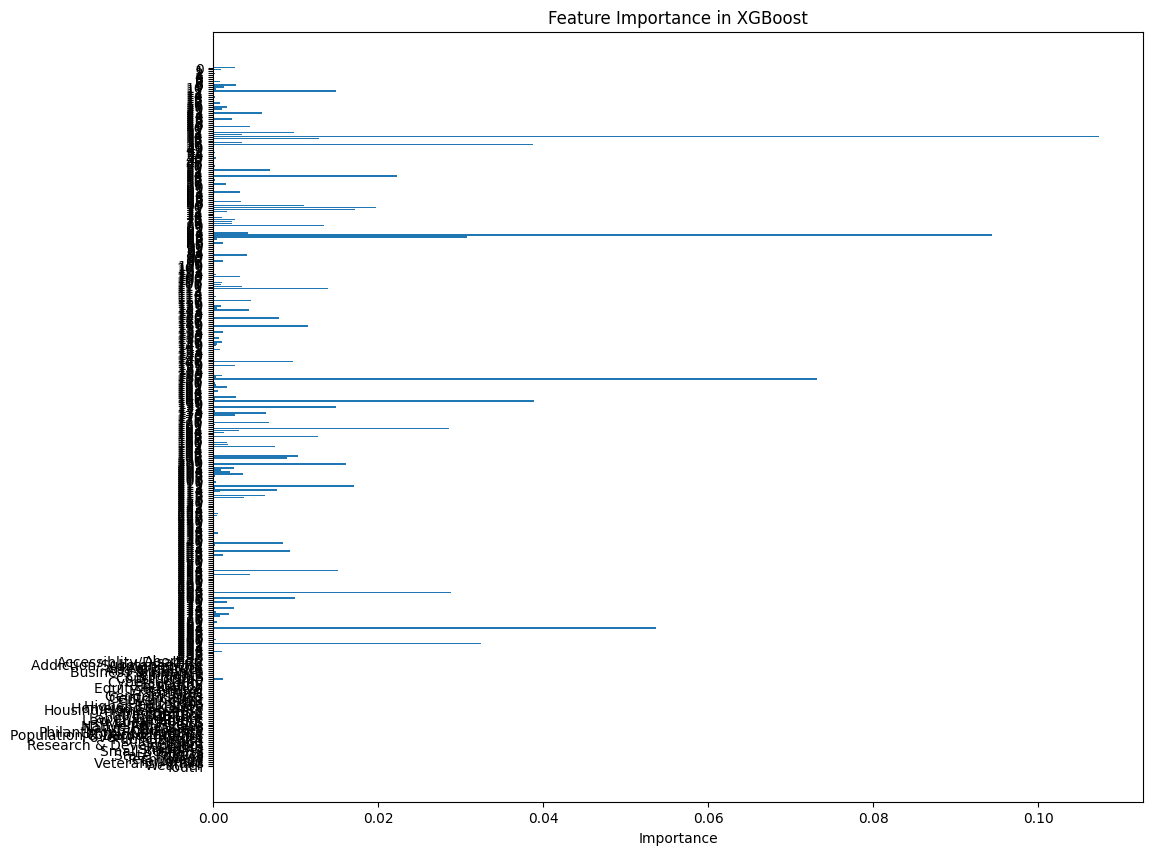

In [10]:
import matplotlib.pyplot as plt

# Assuming xgboost is your trained XGBoost model
importance = xgboost.feature_importances_

# Assuming features_df is your DataFrame of all features including both vectors and one-hot encoded topics
feature_names = features_df.columns  # Ensure this reflects all your feature names correctly

# Visualize feature importance
plt.figure(figsize=(12, 10))
plt.barh(range(len(importance)), importance, align='center')
plt.yticks(range(len(importance)), feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Invert axis to have the most important at the top
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the model
log_reg = LogisticRegression(solver='liblinear')  # 'liblinear' works well with l1 and l2 penalties.

# Create a parameter grid
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Setup the grid search
grid_search_lr = GridSearchCV(estimator=log_reg, param_grid=param_grid_lr, cv=5, scoring='accuracy', verbose=1)

# Fit grid search
grid_search_lr.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search_lr.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_lr.best_score_))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'penalty': 'l1'}
Best cross-validation score: 0.66


In [12]:
from xgboost import XGBClassifier

# Define the model
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create a parameter grid
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9]
}

# Setup the grid search
grid_search_xgb = GridSearchCV(estimator=xgboost, param_grid=param_grid_xgb, cv=5, scoring='accuracy', verbose=1)

# Fit grid search
grid_search_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search_xgb.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_xgb.best_score_))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation score: 0.69


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier  # Import XGBClassifier
from sklearn.metrics import accuracy_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifiers with the best parameters from GridSearchCV
log_reg = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000)
naive_bayes = GaussianNB()
xgboost = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8, use_label_encoder=False, eval_metric='logloss')

# Train the classifiers
log_reg.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Logistic Regression Accuracy: 0.6444444444444445
Naive Bayes Accuracy: 0.4888888888888889
XGBoost Accuracy: 0.6444444444444445


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the classifier
gbc = GradientBoostingClassifier()

# Create a parameter grid
param_grid_gbc = {
    'learning_rate': [0.01, 0.1, 0.2],  # Controls the contribution of each tree
    'n_estimators': [100, 200, 300],    # Number of boosting stages to perform
    'max_depth': [3, 5, 7],             # Maximum depth of the individual regression estimators
    'subsample': [0.7, 0.8, 0.9],       # The fraction of samples to be used for fitting the individual base learners
    'min_samples_split': [2, 4, 6]      # The minimum number of samples required to split an internal node
}

# Setup the grid search
grid_search_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# Fit grid search
grid_search_gbc.fit(X_train, y_train)

# Display the best parameters and the corresponding score
print("Best parameters:", grid_search_gbc.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_gbc.best_score_))


TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'random_state'

In [78]:
# Initialize the classifier with the best parameters
# Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 300, 'subsample': 0.7} from 4/18
optimized_gbc = GradientBoostingClassifier(**grid_search_gbc.best_params_)

# Train the optimized classifier
optimized_gbc.fit(X_train, y_train)

# Predict on test data
y_pred_gbc = optimized_gbc.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, y_pred_gbc))



Gradient Boosting Classifier Accuracy: 0.7111111111111111


In [79]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_split': 4, 'n_estimators': 100, 'subsample': 0.9}
xgboost = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, min_samples_split=4, n_estimators=100, subsample=0.9)


xgboost.fit(X_train, y_train)


y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))



XGBoost Accuracy: 0.7111111111111111


In [85]:
import numpy as np
import spacy

# Load spaCy model for text vectorization
nlp = spacy.load('en_core_web_md')

# Function to generate word vectors from text
def text_to_vector(text):
    doc = nlp(text)
    return np.mean([token.vector for token in doc if not token.is_stop and not token.is_punct], axis=0, keepdims=True)

# Function to extract additional features (if used during training)
def extract_additional_features(text):
    # Example: return feature array based on custom logic
    return np.zeros(55)  # Placeholder, replace with actual feature extraction logic

# Function to prepare the complete feature set for a list of texts
def prepare_features(texts):
    vectors = np.vstack([text_to_vector(text) for text in texts])
    additional_features = np.vstack([extract_additional_features(text) for text in texts])
    return np.hstack([vectors, additional_features])

# Example texts for prediction
texts = [
    "Barack Obama is black",
    "Donald Trump is a white man",
    "Andrew Yang is an asian man",
    "AOC is latina",
    "Michelle Obama is black",
    "i love black people"
]

# Prepare feature set for the texts
features = prepare_features(texts)
print(features)
# Make predictions using both models
log_reg_predictions = log_reg.predict(features)  # Logistic Regression model
xgb_predictions = xgboost.predict(features)    # XGBoost model

# Print predictions
for text, lr_pred, xgb_pred in zip(texts, log_reg_predictions, xgb_predictions):
    print(f"Text: {text}")
    print(f"Logistic Regression Prediction: {lr_pred}")
    print(f"XGBoost Prediction: {xgb_pred}\n")


[[-2.30016351e+00  2.12230992e+00 -4.67506647e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.90712500e+00  1.80097505e-01 -3.29347754e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.11290002e+00 -1.31639755e+00 -1.38525999e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.59900022e-01 -1.08965492e+00 -2.68400073e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.42083001e+00  1.07916665e+00 -3.89020658e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.93196678e+00  7.66913072e-05 -5.99173355e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
Text: Barack Obama is black
Logistic Regression Prediction: 0
XGBoost Prediction: 1

Text: Donald Trump is a white man
Logistic Regression Prediction: 0
XGBoost Prediction: 1

Text: Andrew Yang is an asian man
Logistic Regression Prediction: 0
XGBoost Prediction: 1

Text: AOC is latina
Logistic Regression Prediction: 0
XGBoost Prediction: 1

Text: Michelle Obama is b